### AUTHOR: ABEEB ADEKUNLE GARBA

### Multiobjective Optimization of the energy system, with the two objectives being the
### Total Annualized Costs (design and operation) and the Global Warming Impact (GWI, design and operation)

### Internal Power Grid (with Linearized AC Power flow equations) + Photovoltaic System (PV) + Fuel Cell + Electroyzer + Battery (BAT) components to cater for a Power Demand (DEM)

In [1]:
import comando
from comando.core import Component, System
import pandas as pd
from comando.interfaces.pyomo import to_pyomo
from datetime import datetime

In [2]:
class ExternalGrid(Component):
    """A source for an arbitrary commodity."""
    def __init__(self, label, max_capacity1):
        """Initialize the Source.

        Arguments
        ---------
        - label : str
            Unique string that serves as an identifier of this Source.
        - price : numeric data
            Price per unit of provided commodity, can be a scalar or a
            pandas Series.
        """
        super().__init__(label)
        
        buy_price = self.make_parameter('buy_price', 0.3) #  $KW
        use_grid = self.make_operational_variable('use_grid', bounds=(0, 5000))
        self.add_expression('buy_cost', 0.3*use_grid)
        self.add_output('OUT', use_grid)
        

        selling_price = self.make_parameter('selling_price', 0.05) # $/KW
        feeding = self.make_operational_variable('feeding', bounds=(0, 4000))
        self.add_expression('sel_cost', 0.05*feeding)
        self.add_input('IN', feeding)
        
        co2_factor = self.make_parameter('co2_factor',0.4)   
        emissions = self["use_grid"] * co2_factor
        self.add_expression('emissions', emissions)

        
        self.add_expression('variable_costs', (use_grid*buy_price)-(feeding*selling_price))

In [3]:
class Demand(Component):
    """A demand requiring a known amount of an arbitrary commodity"""

    def __init__(self, label, data=0):
        """Initialize the Demand.

        Arguments
        ---------
        - label : str
            Unique string that serves as an identifier of this Demand.
        - data : numeric data
            Amount of consumed commodity, can be a scalar or a pandas
            Series.
        """
        super().__init__(label)
        demand = self.make_parameter('demand', data)
        self.add_input('IN', demand)

In [4]:
class Photovoltaic(Component):
    """
    Model of a PV park
    """
    def __init__(self, label, max_capacity):
        """
        Initialization of the maximal capacity
        :param label: Name of the PV park
        :param max_land_use: Maximal allowed land use
        """
        super().__init__(label)

        self.invest_cost = 690  # [€/kW]
        psi = 0.017  # o&m costs

        size = self.make_design_variable("size", bounds=(0, max_capacity))  # [kWp]

        power_factor = self.make_parameter("power_factor")  # [kW/kWp]
        el_out = self.make_operational_variable("el_out")
        self.add_le_constraint(el_out, size * power_factor)

        co2_factor = self.make_parameter('co2_factor', 0.4)       
        emissions = self["el_out"] * co2_factor
        self.add_expression('emissions', emissions)

        n = 27  # lifetime
        i = 0.06
        af = ((1 + i) ** n * i) / ((1 + i) ** n - 1)  # annuity factor
        invest_cost = size * self.invest_cost
        self.add_expression("investment_costs", invest_cost * af)
        self.add_expression("fixed_costs", invest_cost * psi)

        self.add_output("OUT", el_out)

In [5]:
class SimpleBattery(Component):
    """
    Simple model of a battery
    """
    def __init__(self, label, max_capacity3, eff=0.98, invest_cost=800):
        """
        Initialization of the battery model
        :param max_capacity: Maximal allowed capacity of the battery
        """
        super().__init__(label=label)
        efficiency = eff
        self.invest_cost = invest_cost  # [€/kWh] 
        psi = 0.022  # o&m costs
        
        size = self.make_design_variable("size", bounds=(0, max_capacity3))
        electricity_input = self.make_operational_variable("electricity_input")
        electricity_output = self.make_operational_variable("electricity_output")
        SOC = self.make_operational_variable('SOC', bounds=(0, max_capacity3))
        self.add_le_constraint(SOC, size, name='SOC_max')
        state_change = electricity_input * eff - electricity_output / eff
        self.declare_state(SOC, state_change, comando.cyclic, der_bounds=(-max_capacity3, max_capacity3))
       

        co2_factor = self.make_parameter('co2_factor', 170)       
        emissions = self["size"] * co2_factor
        self.add_expression('Des_emissions', emissions)

        n = 12  # lifetime
        i = 0.06
        af = ((1 + i) ** n * i) / ((1 + i) ** n - 1)  # annuity factor
        invest_cost = size * self.invest_cost
        self.add_expression("investment_costs", invest_cost * af)
        self.add_expression("fixed_costs", invest_cost *psi)
        self.add_expression('Dissip_losses', 0.002 * SOC)
        self.add_expression('soc', SOC/size)

        "Add inputs and outputs"
        self.add_input("EL_IN", electricity_input)
        self.add_output("EL_OUT", electricity_output)

In [6]:
class Fuel_cell(Component):
    def __init__(self, label, max_capacity4, eff=0.45, invest_cost=1684): 
        super().__init__(label)
        
        self.invest_cost = invest_cost  # [€/kWh] 
        psi = 0.038  # o&m costs
        
        size = self.make_design_variable('size', bounds=(0, max_capacity4))
        
        H2_input = self.make_operational_variable("H2_input")
        electricity_out = self.make_operational_variable("electricity_out")

        n = 14  # lifetime
        i = 0.06 # interest rate

        af = ((1 + i) ** n * i) / ((1 + i) ** n - 1)           # annuity factor
        psi = 0.038

        invest_cost = size * self.invest_cost
        self.add_le_constraint(H2_input, size, name ='max_H2_input')
        self.add_eq_constraint(electricity_out, H2_input*eff)         # 1kg H2 = 33.3 kWh
        self.add_expression('investment_costs', invest_cost * af)
        self.add_expression('fixed_costs', invest_cost * psi)
        self.add_output('OUT', electricity_out)
        self.add_input('IN', H2_input)

In [7]:
class Electrolyzer(Component):
        def __init__(self, label, max_capacity5, eff = 0.65, invest_cost=1295): 
            super().__init__(label)

            self.invest_cost = invest_cost  # [€/kWh] 
            size = self.make_design_variable('size', bounds=(0, max_capacity5))

            
            electricity_in = self.make_operational_variable("electricity_in")
            H2_output = self.make_operational_variable("H2_output")
            
            
            co2_factor = self.make_parameter('co2_factor', 200) # 200 kg / kWh
            emissions = self["size"] * co2_factor
            self.add_expression('Des_emissions', emissions)
            
            n = 14  # lifetime
            i = 0.06 # interest rate
           
            af = ((1 + i) ** n * i) / ((1 + i) ** n - 1)        # annuity factor
            psi = 0.035
            
            invest_cost = size * self.invest_cost
            self.add_le_constraint(electricity_in, size, name ='max_electricity_in')
            self.add_eq_constraint(H2_output, electricity_in* eff)
            self.add_expression('investment_costs', invest_cost * af)
            self.add_expression('fixed_costs', invest_cost * psi)
            self.add_output('OUT', H2_output)
            self.add_input('IN', electricity_in)

## H2 Sold Class

In [8]:
class H2_sold(Component):
    def __init__(self, label, qty): 
        super().__init__(label)
        Qty = self.make_operational_variable("S_H2")
        price = self.make_parameter('Price', 0.2)            # $/kWh
        
        self.add_le_constraint(Qty, qty, name='SOC_max')
        self.add_expression('income', price * Qty)
        self.add_input('IN', Qty)

## H2 Storage Class

In [9]:
class H2_Storage(Component):
    def __init__(self, label, max_capacity6, eff = 0.65, invest_cost=10): 
        super().__init__(label)


        self.invest_cost = invest_cost  # [€/kWh] 
        size = self.make_design_variable('size', bounds=(0, max_capacity6))
        
        SOC = self.make_operational_variable('SOC', bounds=(0, max_capacity6))
        H2_input = self.make_operational_variable('H2_input')
        H2_output = self.make_operational_variable('H2_output')       
        
        self.add_le_constraint(SOC, size, name='SOC_max')
        state_change = H2_input - H2_output  # Considering 100% efficiency
        self.declare_state(SOC, state_change, comando.cyclic, der_bounds=(-max_capacity6, max_capacity6))
        
        n = 23  # lifetime
        i = 0.06 # interest rate
        
        inv_costs = self.make_parameter('inv_costs', 10)      # $/kw
        
        af = ((1 + i) ** n * i) / ((1 + i) ** n - 1)          # annuity factor
        psi = 0.023
        
        invest_cost = size * self.invest_cost
        self.add_le_constraint(H2_input, size, name ='max_H2_input')
        self.add_expression('investment_costs', invest_cost * af)
        self.add_expression('fixed_costs', invest_cost * psi )
        self.add_output('OUT', H2_output)
        self.add_input('IN', H2_input)

### Initialization of the components and creation of the energy system

In [10]:
demand = Demand('demand')
grid = ExternalGrid('grid', max_capacity1=5000) #5000kW
pv = Photovoltaic('pv', max_capacity=7000) # 7000kW
batt = SimpleBattery('batt', max_capacity3=3000) # 3000kW
fc = Fuel_cell('fc', max_capacity4=500) # In kW
electro = Electrolyzer('electro', max_capacity5=1000) # In kW
h2store = H2_Storage('h2store', max_capacity6=4000)   # In kWh
h2sold = H2_sold('h2sold', qty=100)   # In kWh


ES = System('energy_system')

In [11]:
from OPF_DC import PowerSystem

## Definition of approach and bus data

In [12]:
APPROACH = 'DC'

bus_data = { 
    'B1': dict(P= 1e-3*(-grid['use_grid'] + grid['feeding'])),  #(feed-in: negative, demand: positive)
    'B2': dict(P= 1e-3*(-pv['el_out']), U_base = 0.4),
    'B3': dict(P = 1e-3*(electro['electricity_in']-fc['electricity_out']), U_base=10),
    'B4': dict(P= 1e-3*(demand['demand'] + batt['electricity_input'] - batt['electricity_output']), U_base=0.4)
}

In [13]:
if APPROACH == 'DC':
    bus_data['B1']['theta'] = 0
bus_data

{'B1': {'P': 0.001*grid_feeding - 0.001*grid_use_grid, 'theta': 0},
 'B2': {'P': -0.001*pv_el_out, 'U_base': 0.4},
 'B3': {'P': 0.001*electro_electricity_in - 0.001*fc_electricity_out,
  'U_base': 10},
 'B4': {'P': 0.001*demand_demand + 0.001*batt_electricity_input - 0.001*batt_electricity_output,
  'U_base': 0.4}}

## Definition of the line data

In [14]:
l_12 = 10 
l_13 = 2
l_23 = 10
l_34 = 'Trafo'
line_data = {
    ("B1", "B2"): dict(x=l_12 * 0.00868),
    ("B1", "B3"): dict(x=l_13 * 0.00193),
    ("B2", "B3"): dict(x=l_23 * 0.00193),
    ("B3", "B4"): dict(x= 0.01855)
}
line_data

{('B1', 'B2'): {'x': 0.0868},
 ('B1', 'B3'): {'x': 0.00386},
 ('B2', 'B3'): {'x': 0.0193},
 ('B3', 'B4'): {'x': 0.01855}}

## Creation of the energy system (depending on approach)

In [15]:
ES_label = f'ES_{APPROACH}'
if APPROACH == 'CP':  # CP: Copperplate (no internal power grid)
    ES = comando.System(ES_label)
else:
    # Addition of line capacity limits
    if APPROACH == 'NTC' or APPROACH == 'DC':
        line_data[("B1", "B2")]['S_rate'] = 1.5
        line_data[("B1", "B3")]['S_rate'] = 0.75
        line_data[("B2", "B3")]['S_rate'] = 1
        line_data[("B3", "B4")]['S_rate'] = 1
    else:
        raise NotImplementedError(f'Approach {APPROACH} is not known!')
    ES = PowerSystem(ES_label, line_data, bus_data, kind=APPROACH)
print(line_data)

{('B1', 'B2'): {'x': 0.0868, 'S_rate': 1.5}, ('B1', 'B3'): {'x': 0.00386, 'S_rate': 0.75}, ('B2', 'B3'): {'x': 0.0193, 'S_rate': 1}, ('B3', 'B4'): {'x': 0.01855, 'S_rate': 1}}


In [16]:
ES

System('ES_DC', components={Component('L_B1_B3'), Component('L_B2_B3'), Generic bus B3, Generic bus B1, Generic bus B4, Component('L_B1_B2'), Component('L_B3_B4'), Generic bus B2}, connections={'B1_P': {Connector(Component('L_B1_B2'), 'P_FROM', 11.5207373271889*B1_theta - 11.5207373271889*B2_theta), Connector(Generic bus B1, 'P', 0.001*grid_feeding - 0.001*grid_use_grid), Connector(Component('L_B1_B3'), 'P_FROM', 259.067357512953*B1_theta - 259.067357512953*B3_theta)}, 'B2_P': {Connector(Component('L_B2_B3'), 'P_FROM', 51.8134715025907*B2_theta - 51.8134715025907*B3_theta), Connector(Component('L_B1_B2'), 'P_TO', -11.5207373271889*B1_theta + 11.5207373271889*B2_theta), Connector(Generic bus B2, 'P', -0.001*pv_el_out)}, 'B3_P': {Connector(Generic bus B3, 'P', 0.001*electro_electricity_in - 0.001*fc_electricity_out), Connector(Component('L_B3_B4'), 'P_FROM', 53.9083557951482*B3_theta - 53.9083557951482*B4_theta), Connector(Component('L_B1_B3'), 'P_TO', -259.067357512953*B1_theta + 259.06

### Adding components to energy system

In [17]:
comp = [demand, grid, pv, batt, fc, electro, h2store, h2sold]
for c in comp:
    ES.add(c)
print(ES)

System('ES_DC', components={Component('L_B1_B3'), Component('L_B2_B3'), Component('grid'), Component('batt'), Generic bus B3, Component('fc'), Component('h2store'), Generic bus B1, Generic bus B4, Component('h2sold'), Component('L_B1_B2'), Component('L_B3_B4'), Generic bus B2, Component('demand'), Component('electro'), Component('pv')}, connections={'B1_P': {Connector(Component('L_B1_B2'), 'P_FROM', 11.5207373271889*B1_theta - 11.5207373271889*B2_theta), Connector(Generic bus B1, 'P', 0.001*grid_feeding - 0.001*grid_use_grid), Connector(Component('L_B1_B3'), 'P_FROM', 259.067357512953*B1_theta - 259.067357512953*B3_theta)}, 'B2_P': {Connector(Component('L_B2_B3'), 'P_FROM', 51.8134715025907*B2_theta - 51.8134715025907*B3_theta), Connector(Component('L_B1_B2'), 'P_TO', -11.5207373271889*B1_theta + 11.5207373271889*B2_theta), Connector(Generic bus B2, 'P', -0.001*pv_el_out)}, 'B3_P': {Connector(Generic bus B3, 'P', 0.001*electro_electricity_in - 0.001*fc_electricity_out), Connector(Compo

### Setting the connections

In [18]:
if APPROACH == 'CP':
    ES.connect('Electricity_bus', [fc.IN, electro.OUT, h2sold.IN, h2store.IN])
print(ES.connections)

{'B1_P': {Connector(Component('L_B1_B2'), 'P_FROM', 11.5207373271889*B1_theta - 11.5207373271889*B2_theta), Connector(Generic bus B1, 'P', 0.001*grid_feeding - 0.001*grid_use_grid), Connector(Component('L_B1_B3'), 'P_FROM', 259.067357512953*B1_theta - 259.067357512953*B3_theta)}, 'B2_P': {Connector(Component('L_B2_B3'), 'P_FROM', 51.8134715025907*B2_theta - 51.8134715025907*B3_theta), Connector(Component('L_B1_B2'), 'P_TO', -11.5207373271889*B1_theta + 11.5207373271889*B2_theta), Connector(Generic bus B2, 'P', -0.001*pv_el_out)}, 'B3_P': {Connector(Generic bus B3, 'P', 0.001*electro_electricity_in - 0.001*fc_electricity_out), Connector(Component('L_B3_B4'), 'P_FROM', 53.9083557951482*B3_theta - 53.9083557951482*B4_theta), Connector(Component('L_B1_B3'), 'P_TO', -259.067357512953*B1_theta + 259.067357512953*B3_theta), Connector(Component('L_B2_B3'), 'P_TO', -51.8134715025907*B2_theta + 51.8134715025907*B3_theta)}, 'B4_P': {Connector(Component('L_B3_B4'), 'P_TO', -53.9083557951482*B3_the

### Data handling

In [19]:
pv_data = pd.read_csv("ninja_pv_10.5155_9.3215_Bauchi.csv",
    skiprows=[0, 1, 2],
    usecols=[0, 1, 2],
    parse_dates=['time', 'local_time'])
name = 'pv_power_factor'
pv_data = pv_data.rename(columns={"electricity": name})  
pv_data[name] = pv_data[name] 

pv_data['hour'] = pv_data.index % 24
pv_data['day'] = pv_data.index // 24  
daily_pv = pv_data[[name, 'day', 'hour']] \
    .set_index(['day', 'hour']).unstack()[name]  
daily_pv

hour  0   1   2   3   4     5     6     7     8     9   ...    14    15    16  \
day                                                     ...                     
0      0   0   0   0   0     0 0.182 0.433 0.607 0.721  ...  0.54 0.354 0.112   
1      0   0   0   0   0 0.001 0.179 0.434 0.615 0.713  ... 0.528 0.332 0.091   
2      0   0   0   0   0     0 0.142  0.38 0.565 0.688  ... 0.487 0.288 0.069   
3      0   0   0   0   0     0 0.089 0.266 0.451 0.621  ... 0.511 0.303 0.063   
4      0   0   0   0   0     0 0.146 0.304 0.391 0.467  ... 0.487 0.312 0.079   
..    ..  ..  ..  ..  ..   ...   ...   ...   ...   ...  ...   ...   ...   ...   
360    0   0   0   0   0     0 0.129 0.375 0.567 0.704  ... 0.512 0.316 0.087   
361    0   0   0   0   0     0 0.184 0.437 0.615 0.736  ... 0.555 0.367 0.113   
362    0   0   0   0   0 0.001 0.201 0.455 0.627 0.745  ... 0.562 0.374 0.125   
363    0   0   0   0   0     0 0.156 0.398 0.576 0.702  ... 0.557 0.375 0.128   
364    0   0   0   0   0 0.001 0.213 0.462 0.629  0.74  ... 0.568 0.381 0.127   

hour  17  18  19  20  21  22  23  
day                               
0      0   0   0   0   0   0   0  
1      0   0   0   0   0   0   0  
2      0   0   0   0   0   0   0  
3      0   0   0   0   0   0   0  
4      0   0   0   0   0   0   0  
..    ..  ..  ..  ..  ..  ..  ..  
360    0   0   0   0   0   0   0  
361    0   0   0   0   0   0   0  
362    0   0   0   0   0   0   0  
363    0   0   0   0   0   0   0  
364    0   0   0   0   0   0   0  

[365 rows x 24 columns]

## Clustering of PV Data

In [20]:
pv_max = daily_pv.max().max()
daily_pv_norm = daily_pv/pv_max
daily_pv_norm

hour  0   1   2   3   4        5      6      7      8      9   ...     14  \
day                                                            ...          
0      0   0   0   0   0        0 0.2247 0.5346 0.7494 0.8901  ... 0.6667   
1      0   0   0   0   0 0.001235  0.221 0.5358 0.7593 0.8802  ... 0.6519   
2      0   0   0   0   0        0 0.1753 0.4691 0.6975 0.8494  ... 0.6012   
3      0   0   0   0   0        0 0.1099 0.3284 0.5568 0.7667  ... 0.6309   
4      0   0   0   0   0        0 0.1802 0.3753 0.4827 0.5765  ... 0.6012   
..    ..  ..  ..  ..  ..      ...    ...    ...    ...    ...  ...    ...   
360    0   0   0   0   0        0 0.1593  0.463    0.7 0.8691  ... 0.6321   
361    0   0   0   0   0        0 0.2272 0.5395 0.7593 0.9086  ... 0.6852   
362    0   0   0   0   0 0.001235 0.2481 0.5617 0.7741 0.9198  ... 0.6938   
363    0   0   0   0   0        0 0.1926 0.4914 0.7111 0.8667  ... 0.6877   
364    0   0   0   0   0 0.001235  0.263 0.5704 0.7765 0.9136  ... 0.7012   

hour     15      16  17  18  19  20  21  22  23  
day                                              
0     0.437  0.1383   0   0   0   0   0   0   0  
1    0.4099  0.1123   0   0   0   0   0   0   0  
2    0.3556 0.08519   0   0   0   0   0   0   0  
3    0.3741 0.07778   0   0   0   0   0   0   0  
4    0.3852 0.09753   0   0   0   0   0   0   0  
..      ...     ...  ..  ..  ..  ..  ..  ..  ..  
360  0.3901  0.1074   0   0   0   0   0   0   0  
361  0.4531  0.1395   0   0   0   0   0   0   0  
362  0.4617  0.1543   0   0   0   0   0   0   0  
363   0.463   0.158   0   0   0   0   0   0   0  
364  0.4704  0.1568   0   0   0   0   0   0   0  

[365 rows x 24 columns]

In [21]:
from sklearn_extra.cluster import KMedoids
# n is the number of typical days we want the clustering algorithm to output
n = 8
clusters = KMedoids(n_clusters=n).fit(daily_pv_norm)
print(clusters.medoid_indices_)
print(clusters.labels_)  # 365 entries for each day 

[ 85 261 138 246 136  38 115  65]
[5 5 5 7 0 5 7 4 5 5 5 5 5 7 7 5 5 5 5 5 5 5 5 5 5 5 5 0 5 5 5 2 1 5 5 5 2
 5 5 5 7 7 7 5 5 2 7 7 7 7 7 0 0 1 6 1 3 1 1 4 5 5 7 5 7 7 0 7 0 5 1 7 1 6
 0 2 7 7 0 7 0 2 0 7 4 0 7 7 7 2 0 2 7 7 7 0 0 1 6 6 2 0 6 6 0 0 2 0 6 2 2
 6 6 6 4 6 0 0 2 2 6 3 6 2 3 2 2 6 3 6 6 3 3 2 6 3 4 2 2 3 3 2 2 2 6 3 6 3
 3 3 3 3 3 6 4 3 3 3 3 6 2 6 6 4 6 2 2 2 2 2 3 3 3 3 3 6 3 4 3 2 6 4 3 3 3
 3 4 6 3 3 6 3 3 2 6 6 6 2 3 3 4 3 4 6 3 3 6 6 2 3 6 6 3 3 6 3 4 6 3 2 3 4
 2 4 2 1 3 4 3 6 3 1 3 0 6 3 1 4 3 3 3 0 1 4 0 4 3 2 0 0 3 2 0 0 0 0 3 3 4
 7 0 1 4 1 0 0 6 3 4 4 7 2 4 4 3 4 4 3 3 3 2 1 3 6 4 2 7 6 0 1 3 0 0 0 0 0
 6 3 7 4 4 7 5 7 7 7 7 5 5 5 5 5 5 7 4 7 3 7 5 5 5 5 5 7 7 5 7 5 5 5 5 5 5
 5 5 5 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5]


In [22]:
pv_clusters = pd.Series(clusters.labels_, daily_pv.index)
pv_clusters

day
0      5
1      5
2      5
3      7
4      0
      ..
360    5
361    5
362    5
363    5
364    5
Length: 365, dtype: int64

In [23]:
pv_scenarios = daily_pv.iloc[clusters.medoid_indices_].sort_index()
pv_scenarios

hour  0   1   2   3   4     5     6     7     8     9   ...    14    15    16  \
day                                                     ...                     
38     0   0   0   0   0 0.003 0.176  0.41 0.587 0.701  ... 0.534 0.343 0.108   
65     0   0   0   0   0 0.005 0.132 0.324 0.489   0.6  ... 0.432 0.256 0.078   
85     0   0   0   0   0 0.008 0.123 0.277 0.423 0.544  ... 0.402 0.241 0.079   
115    0   0   0   0   0 0.011 0.107  0.24 0.374 0.481  ... 0.262 0.142 0.046   
136    0   0   0   0   0 0.006 0.067 0.187 0.317 0.445  ... 0.327 0.191 0.074   
138    0   0   0   0   0 0.016 0.113 0.248  0.37 0.475  ... 0.339 0.209 0.067   
246    0   0   0   0   0 0.008 0.099 0.228  0.33 0.383  ... 0.218  0.13 0.043   
261    0   0   0   0   0 0.009 0.151 0.329 0.461 0.556  ...  0.26 0.135 0.056   

hour    17  18  19  20  21  22  23  
day                                 
38       0   0   0   0   0   0   0  
65       0   0   0   0   0   0   0  
85       0   0   0   0   0   0   0  
115      0   0   0   0   0   0   0  
136  0.004   0   0   0   0   0   0  
138  0.002   0   0   0   0   0   0  
246      0   0   0   0   0   0   0  
261      0   0   0   0   0   0   0  

[8 rows x 24 columns]

In [24]:
cluster_order = clusters.medoid_indices_.argsort()
daily_pv.groupby(pv_clusters).size()

0    38
1    18
2    40
3    67
4    31
5    84
6    44
7    43
dtype: int64

In [25]:
weights = daily_pv.groupby(pv_clusters).size().div(365)[cluster_order]
weights.index = pv_scenarios.index
weights

day
38     0.2301
65     0.1178
85     0.1041
115    0.1205
136   0.08493
138    0.1096
246    0.1836
261   0.04932
dtype: float64

### Plotting of clustered data

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17436\2967974868.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Dark2")    # This colormap only has 8 colors, therefore it can only plot up to 8 clusters


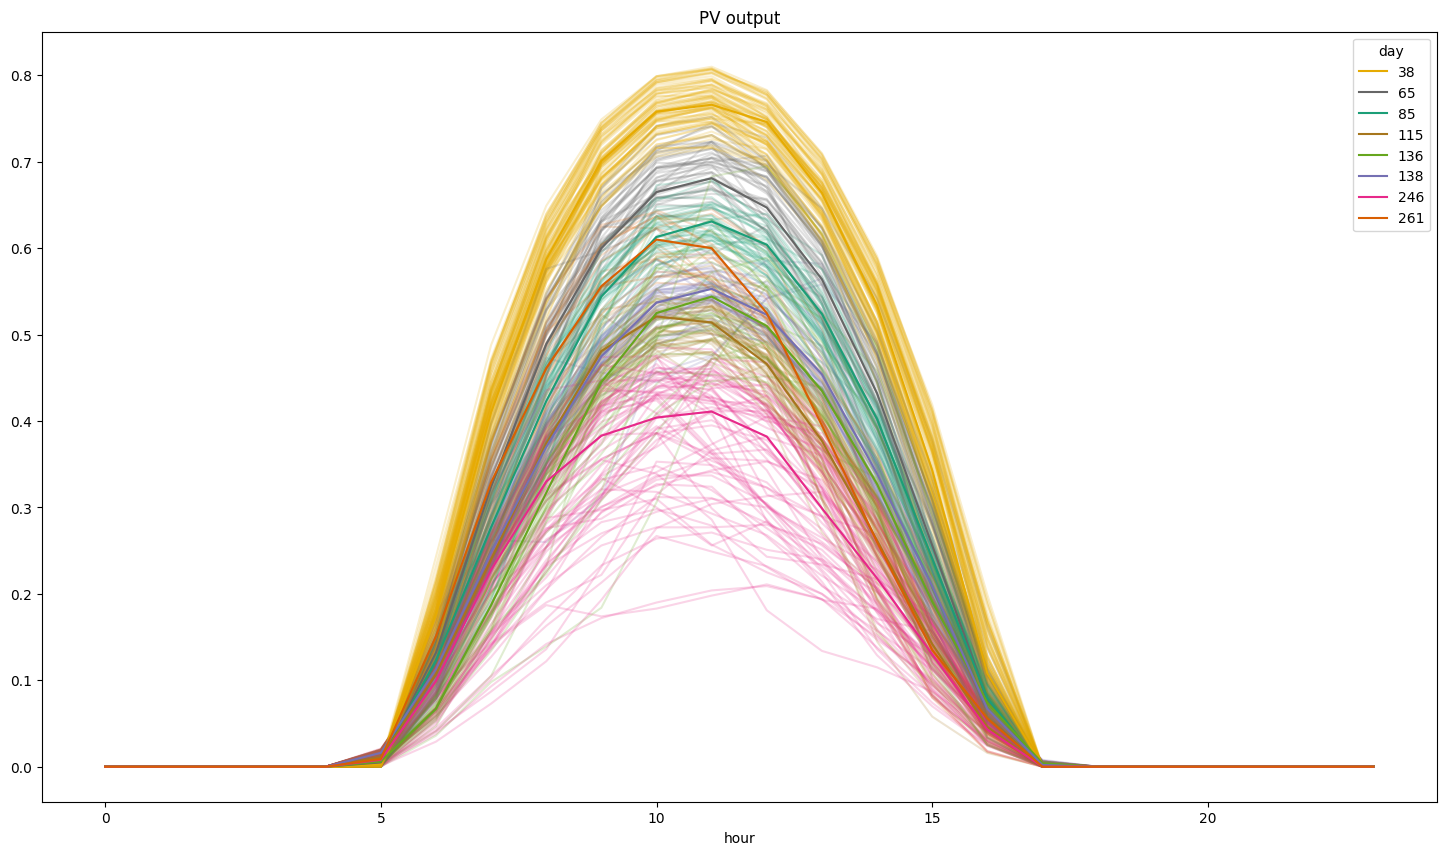

In [26]:
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
cmap = get_cmap("Dark2")    
colors = pv_clusters.apply(lambda v: cmap.colors[v])

fig, ax = plt.subplots(1, sharex=True, gridspec_kw=dict(hspace=0, wspace=0.01), figsize=(18, 10))  
ax.set_title('PV output') 

daily_pv.T.plot(ax=ax, legend=False, color=colors, alpha=0.2)  
pv_scenarios.T.plot(ax=ax, color=[cmap.colors[i] for i in cluster_order]) 
plt.savefig(f'cluster_Subtask1.png', bbox_inches='tight')
plt.show()

### Addition of max. and min. solar irradiation

In [27]:
daily_pv

hour  0   1   2   3   4     5     6     7     8     9   ...    14    15    16  \
day                                                     ...                     
0      0   0   0   0   0     0 0.182 0.433 0.607 0.721  ...  0.54 0.354 0.112   
1      0   0   0   0   0 0.001 0.179 0.434 0.615 0.713  ... 0.528 0.332 0.091   
2      0   0   0   0   0     0 0.142  0.38 0.565 0.688  ... 0.487 0.288 0.069   
3      0   0   0   0   0     0 0.089 0.266 0.451 0.621  ... 0.511 0.303 0.063   
4      0   0   0   0   0     0 0.146 0.304 0.391 0.467  ... 0.487 0.312 0.079   
..    ..  ..  ..  ..  ..   ...   ...   ...   ...   ...  ...   ...   ...   ...   
360    0   0   0   0   0     0 0.129 0.375 0.567 0.704  ... 0.512 0.316 0.087   
361    0   0   0   0   0     0 0.184 0.437 0.615 0.736  ... 0.555 0.367 0.113   
362    0   0   0   0   0 0.001 0.201 0.455 0.627 0.745  ... 0.562 0.374 0.125   
363    0   0   0   0   0     0 0.156 0.398 0.576 0.702  ... 0.557 0.375 0.128   
364    0   0   0   0   0 0.001 0.213 0.462 0.629  0.74  ... 0.568 0.381 0.127   

hour  17  18  19  20  21  22  23  
day                               
0      0   0   0   0   0   0   0  
1      0   0   0   0   0   0   0  
2      0   0   0   0   0   0   0  
3      0   0   0   0   0   0   0  
4      0   0   0   0   0   0   0  
..    ..  ..  ..  ..  ..  ..  ..  
360    0   0   0   0   0   0   0  
361    0   0   0   0   0   0   0  
362    0   0   0   0   0   0   0  
363    0   0   0   0   0   0   0  
364    0   0   0   0   0   0   0  

[365 rows x 24 columns]

In [28]:
cluster_order

array([5, 7, 0, 6, 4, 2, 3, 1], dtype=int64)

In [29]:
n_days = len(daily_pv)
weights *= (n_days - 2) / n_days

# day with minimal and maximal pv irridiation
min_day = daily_pv.max(1).argmin()
max_day = daily_pv.values.argmax() // 24

# pv on minimal and maximal days
pv_daily_min = daily_pv.iloc[min_day]  
pv_daily_max = daily_pv.iloc[max_day]

# add minimal and maximal days with data to pv_scenarios
pv_scenarios.loc[min_day] = pv_daily_min
pv_scenarios.loc[max_day] = pv_daily_max

weights[min_day] = 1 / n_days
weights[max_day] = 1 / n_days
weights.sort_index(inplace=True)
weights *= 365 
pv_scenarios.sort_index(inplace=True) 

### Demand data handling

In [30]:
demand_data = pd.read_csv('demand_data.csv',
                          usecols=[0, 1],
                          parse_dates=['time'],
                          date_parser=lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M'))
annual_demand = demand_data.groupby(pd.Grouper(freq='H', key='time')).mean().reset_index()
name = 'electricity_demand'
demand_data = annual_demand.rename(columns={"electricity": name})
demand_data['hour'] = demand_data.index % 24
demand_data['day'] = demand_data.index // 24 
demand_daily = demand_data[[name, 'day', 'hour']] \
    .set_index(['day', 'hour']).unstack()[name]
demand_cluster = demand_daily.loc[pv_scenarios.index]
demand_cluster

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17436\2769972099.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  demand_data = pd.read_csv('demand_data.csv',
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17436\2769972099.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  annual_demand = demand_data.groupby(pd.Grouper(freq='H', key='time')).mean().reset_index()


hour    0     1     2     3     4     5     6     7     8     9   ...    14  \
day                                                               ...         
38   321.1 323.1 317.3 316.2 311.2 309.6   316   320 324.5 329.4  ... 333.8   
65   344.6 343.4 338.2 338.6 343.4 340.6 339.4 341.3   338 336.9  ... 334.7   
85   320.6 326.2 327.3 327.7 326.2 324.7 323.3 320.3 315.9 316.7  ... 321.7   
115  308.3 308.2 307.3 306.5 309.4 354.8 433.4 559.3 599.1 588.7  ... 527.2   
136  312.7 316.9 314.3 314.5 313.5 312.9   326 331.8 331.2 329.2  ... 337.9   
138  315.9 317.4   313 308.4 313.2 345.2 409.2 490.9 545.3 546.6  ... 537.9   
226  290.5 290.3 286.4 290.3 289.5   290   290 290.2 291.4 291.6  ... 297.2   
246  293.6 296.1 290.6 290.1 291.5 290.7 290.3 290.8 287.1   291  ... 298.1   
261  284.4 285.2 283.9 280.8 284.6 285.3 288.1 283.3 284.7 287.9  ... 286.4   
356  350.3 344.2 336.6 336.4 331.8 332.6   373 450.1   540   599  ... 549.2   

hour    15    16    17    18    19    20    21    22    23  
day                                                         
38     336   337 340.9 339.6 329.4 322.6 319.2 318.9   318  
65   328.5 334.1 331.3   336 345.8 348.6 339.5 335.9 335.7  
85     312 309.8 308.7 306.8 308.7 314.8 317.6 314.7 314.2  
115  507.9   452 389.1 346.1 328.3 323.5 322.8 317.2 317.8  
136  335.8 340.7   339 325.1 316.5 311.4 309.3 310.2   309  
138  501.1 439.7 386.3 338.7 313.9   313 302.6 299.4 300.4  
226    294 300.7   302 300.4   302 301.4 297.8   298 295.9  
246  295.7 295.8 292.6 291.2 292.4 293.4 295.3 296.2 295.9  
261    287 285.1 284.1 285.2 294.1   287 288.2 287.5 287.4  
356  533.5 506.6 440.1 387.1 356.3 340.6 336.3 327.9 325.4  

[10 rows x 24 columns]

In [31]:
demand_cluster

hour    0     1     2     3     4     5     6     7     8     9   ...    14  \
day                                                               ...         
38   321.1 323.1 317.3 316.2 311.2 309.6   316   320 324.5 329.4  ... 333.8   
65   344.6 343.4 338.2 338.6 343.4 340.6 339.4 341.3   338 336.9  ... 334.7   
85   320.6 326.2 327.3 327.7 326.2 324.7 323.3 320.3 315.9 316.7  ... 321.7   
115  308.3 308.2 307.3 306.5 309.4 354.8 433.4 559.3 599.1 588.7  ... 527.2   
136  312.7 316.9 314.3 314.5 313.5 312.9   326 331.8 331.2 329.2  ... 337.9   
138  315.9 317.4   313 308.4 313.2 345.2 409.2 490.9 545.3 546.6  ... 537.9   
226  290.5 290.3 286.4 290.3 289.5   290   290 290.2 291.4 291.6  ... 297.2   
246  293.6 296.1 290.6 290.1 291.5 290.7 290.3 290.8 287.1   291  ... 298.1   
261  284.4 285.2 283.9 280.8 284.6 285.3 288.1 283.3 284.7 287.9  ... 286.4   
356  350.3 344.2 336.6 336.4 331.8 332.6   373 450.1   540   599  ... 549.2   

hour    15    16    17    18    19    20    21    22    23  
day                                                         
38     336   337 340.9 339.6 329.4 322.6 319.2 318.9   318  
65   328.5 334.1 331.3   336 345.8 348.6 339.5 335.9 335.7  
85     312 309.8 308.7 306.8 308.7 314.8 317.6 314.7 314.2  
115  507.9   452 389.1 346.1 328.3 323.5 322.8 317.2 317.8  
136  335.8 340.7   339 325.1 316.5 311.4 309.3 310.2   309  
138  501.1 439.7 386.3 338.7 313.9   313 302.6 299.4 300.4  
226    294 300.7   302 300.4   302 301.4 297.8   298 295.9  
246  295.7 295.8 292.6 291.2 292.4 293.4 295.3 296.2 295.9  
261    287 285.1 284.1 285.2 294.1   287 288.2 287.5 287.4  
356  533.5 506.6 440.1 387.1 356.3 340.6 336.3 327.9 325.4  

[10 rows x 24 columns]

### Objective functions and timesteps

In [32]:
operational_obj = grid['variable_costs'] - h2sold['income']
dv_fixed_cost = ES.aggregate_component_expressions("fixed_costs")
dv_invest_cost = ES.aggregate_component_expressions('investment_costs')
investment_costs = dv_fixed_cost + dv_invest_cost
ts = (daily_pv.columns, 24)

### Problem creation

In [33]:
weights

day
38    83.54
65    42.76
85    37.79
115   43.76
136   30.83
138   39.78
226       1
246   66.63
261    17.9
356       1
dtype: float64

In [34]:
P = ES.create_problem(design_objective=investment_costs, 
                      operational_objective=operational_obj, 
                      timesteps=ts, 
                      scenarios=weights.to_dict(),
                      name='Subtask_3.2')
print(P)

Problem(name='Subtask_3.2')


In [35]:
print(f'Constraints of the problem: \n   {P.constraints} \n')
print(f'Operational objective: \n   {P.operational_objective} \n')
print(f'Design objective: \n   {P.design_objective} \n')

Constraints of the problem: 
   {'ES_DC_B1_P': Eq(270.588094840142*B1_theta - 11.5207373271889*B2_theta - 259.067357512953*B3_theta + 0.001*grid_feeding - 0.001*grid_use_grid, 0), 'ES_DC_B2_P': Eq(-11.5207373271889*B1_theta + 63.3342088297796*B2_theta - 51.8134715025907*B3_theta - 0.001*pv_el_out, 0), 'ES_DC_B3_P': Eq(-259.067357512953*B1_theta - 51.8134715025907*B2_theta + 364.789184810692*B3_theta - 53.9083557951482*B4_theta + 0.001*electro_electricity_in - 0.001*fc_electricity_out, 0), 'ES_DC_B4_P': Eq(0.001*demand_demand - 53.9083557951482*B3_theta + 53.9083557951482*B4_theta + 0.001*batt_electricity_input - 0.001*batt_electricity_output, 0), 'h2sold_SOC_max': h2sold_S_H2 <= 100, 'L_B1_B2_S_rate_from': 11.5207373271889*B1_theta - 11.5207373271889*B2_theta <= 1.5, 'L_B1_B2_S_rate_to': -11.5207373271889*B1_theta + 11.5207373271889*B2_theta <= 1.5, 'demand_IN': 0 <= demand_demand, 'electro_max_electricity_in': electro_electricity_in <= electro_size, 'electro_electro_H2_output = 0.65*e

In [36]:
P.parameters

{B1_theta,
 demand_demand,
 grid_buy_price,
 grid_selling_price,
 h2sold_Price,
 pv_power_factor}

In [37]:
P.data

#Setting the demand data in the problem formulation

In [38]:
data = pd.DataFrame()
data['demand'] = demand_cluster.values.reshape(-1)  
data['pv_power_factor'] = pv_scenarios.values.reshape(-1)
P['demand_demand'] = data['demand']
P['pv_power_factor'] = data['pv_power_factor']
data['demand']

0     321.1
1     323.1
2     317.3
3     316.2
4     311.2
       ... 
235   356.3
236   340.6
237   336.3
238   327.9
239   325.4
Name: demand, Length: 240, dtype: float64

### Create a pyomo model from our created problem

In [39]:
from comando.interfaces.pyomo import to_pyomo
m = to_pyomo(P)

### Solving the problem with GLPK

In [40]:
options = dict(mipgap=0.01)
m.solve('glpk', options=options)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 86930.2927746119
  Upper bound: 86930.2927746119
  Number of objectives: 1
  Number of constraints: 6240
  Number of variables: 4566
  Number of nonzeros: 13562
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.23120546340942383
# ----------------------------------------------------------
#   Solution Information
# -----

{'Problem': [{'Name': 'unknown', 'Lower bound': 86930.2927746119, 'Upper bound': 86930.2927746119, 'Number of objectives': 1, 'Number of constraints': 6240, 'Number of variables': 4566, 'Number of nonzeros': 13562, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.23120546340942383}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Return the solution

In [41]:
dv = P.design
Total_cost = P.objective.value
ov = P.operation.T
ov["electricity_demand"] = data["demand"].values
ov["pv_power_factor"] = data["pv_power_factor"].values
ov["power_max"] = ov["pv_power_factor"] * dv.loc['pv_size']['value']
ov
print(ov)

name     B2_theta   B3_theta  B4_theta  batt_SOC  batt_SOCdot  \
s   t                                                           
38  0  -0.0002929  -0.000358 -0.006315         0            0   
    1   -0.000299 -0.0003655  -0.00636         0            0   
    2  -0.0002812 -0.0003437 -0.006229         0            0   
    3  -0.0002778 -0.0003396 -0.006205         0            0   
    4  -0.0002627 -0.0003211 -0.006094         0            0   
...           ...        ...       ...       ...          ...   
356 19 -0.0004001 -0.0004891 -0.007099         0            0   
    20 -0.0003522 -0.0004306 -0.006749         0            0   
    21 -0.0003393 -0.0004147 -0.006654         0            0   
    22 -0.0003136 -0.0003833 -0.006466         0            0   
    23 -0.0003059  -0.000374  -0.00641         0            0   

name    batt_electricity_input  batt_electricity_output  electro_H2_output  \
s   t                                                                       

In [42]:
dv

value
name               
batt_size         0
electro_size      0
fc_size         500
h2store_size      0
pv_size       1,683

In [43]:
investment_costs

113.021623504531*batt_size + 184.647457162893*electro_size + 245.164986766265*fc_size + 1.04278484688789*h2store_size + 63.961044767334*pv_size

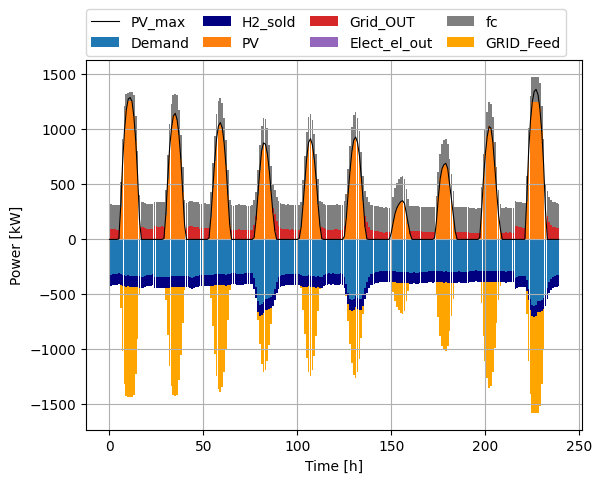

In [44]:
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, sharex=True, gridspec_kw=dict(hspace=0, wspace=0.01))
hours = np.linspace(0, len(ov) - 1, len(ov))

ax.bar(hours, -ov['electricity_demand'].values, width=0.9, label='Demand', color='tab:blue')

ax.bar(hours, -ov['h2sold_S_H2'].values,
       bottom=-ov['electricity_demand'].values, width=0.9, label='H2_sold', color='navy')

ax.bar(hours, ov['pv_el_out'].values, width=0.9, label='PV', color='tab:orange')

ax.bar(hours, ov['grid_use_grid'].values, bottom=ov['pv_el_out'].values, width=0.9, label='Grid_OUT', color='tab:red')

ax.bar(hours, ov['electro_H2_output'].values, 
       bottom= ov['pv_el_out'].values + ov['grid_use_grid'].values, 
       width=0.9, label='Elect_el_out', color='tab:purple')


ax.bar(hours, ov['fc_electricity_out'].values, bottom=ov['pv_el_out'].values+ov['grid_use_grid'].values, width=0.9, label='fc', color='tab:gray')

ax.bar(hours, -ov['grid_feeding'].values, bottom=-ov['electricity_demand'].values-ov['h2sold_S_H2'].values, width=0.9, label='GRID_Feed', color='orange')
, width=0.9, label='fc', color='tab:gray')

ax.plot(hours, ov['power_max'].values, label='PV_max', linewidth=0.8, color='black')
ax.set_ylabel('Power [kW]')
ax.set_xlabel('Time [h]')

fig.legend(loc='upper center', ncol=4, columnspacing=1, bbox_to_anchor=(0.5, 1.00))
plt.grid()
plt.show()

In [45]:
ov.head(40)


name    B2_theta   B3_theta  B4_theta  batt_SOC  batt_SOCdot  \
s  t                                                           
38 0  -0.0002929  -0.000358 -0.006315         0            0   
   1   -0.000299 -0.0003655  -0.00636         0            0   
   2  -0.0002812 -0.0003437 -0.006229         0            0   
   3  -0.0002778 -0.0003396 -0.006205         0            0   
   4  -0.0002627 -0.0003211 -0.006094         0            0   
   5  -0.0001654 -0.0002996 -0.006042         0            0   
   6    0.005139  0.0005638 -0.005298         0            0   
   7     0.01233   0.001749 -0.004187         0            0   
   8     0.01776    0.00264  -0.00338         0            0   
   9       0.021   0.002895 -0.003215         0            0   
   10    0.02219   0.002895 -0.003106         0            0   
   11    0.02219   0.002895  -0.00324         0            0   
   12    0.02219   0.002895 -0.003226         0            0   
   13    0.02002   0.002895 -0.003271         0            0   
   14     0.0161   0.002334 -0.003858         0            0   
   15    0.01022   0.001346 -0.004887         0            0   
   16   0.002982  0.0001368 -0.006115         0            0   
   17 -0.0003532 -0.0004317 -0.006756         0            0   
   18 -0.0003492 -0.0004268 -0.006726         0            0   
   19  -0.000318 -0.0003887 -0.006498         0            0   
   20 -0.0002974 -0.0003635 -0.006348         0            0   
   21 -0.0002871  -0.000351 -0.006273         0            0   
   22  -0.000286 -0.0003497 -0.006265         0            0   
   23 -0.0002834 -0.0003465 -0.006246         0            0   
65 0  -0.0003644 -0.0004454 -0.006837         0            0   
   1  -0.0003608 -0.0004411 -0.006812         0            0   
   2  -0.0003448 -0.0004215 -0.006695         0            0   
   3  -0.0003462 -0.0004232 -0.006705         0            0   
   4  -0.0003606 -0.0004408  -0.00681         0            0   
   5  -0.0001985 -0.0004051 -0.006724         0            0   
   6    0.003713  0.0002508 -0.006046         0   -4.547e-13   
   7    0.009616   0.001228 -0.005103         0            0   
   8      0.0147   0.002087 -0.004184         0            0   
   9     0.01812   0.002661 -0.003589         0            0   
   10    0.02004   0.002895 -0.003243         0            0   
   11    0.02047   0.002895 -0.003296         0            0   
   12    0.01956   0.002895 -0.003313         0            0   
   13    0.01702   0.002478 -0.003759         0            0   
   14    0.01296   0.001807 -0.004401         0            0   
   15   0.007563  0.0009275 -0.005166         0            0   

name   batt_electricity_input  batt_electricity_output  electro_H2_output  \
s  t                                                                        
38 0                        0                        0                  0   
   1                        0                        0                  0   
   2                        0                        0                  0   
   3                        0                        0                  0   
   4                        0                        0                  0   
   5                        0                        0                  0   
   6                        0                        0                  0   
   7                        0                        0                  0   
   8                        0                        0                  0   
   9                        0                        0                  0   
   10                       0                        0                  0   
   11                       0                        0                  0   
   12                       0                        0                  0   
   13                       0                        0                  0   
   14                       0                        0                  0   
  

## Multiobjective Formulation
Definition of objectives

In [46]:
import os
os.chdir("C:/Users/LENOVO/Desktop/New Desktop/3RD Semester/8-Creativity_Lab_training-20240927T114136Z-001/Second Batch/comando_folder/comando")
from examples.IES.user_defined_algorithm import make_multiobjective, \
    solve_multiobjective
vc = grid['variable_costs'] 
emissions = 1e-3*grid['emissions'] 

data['demand_demand'] = demand_cluster.values.reshape(-1)
data['pv_power_factor'] = pv_scenarios.values.reshape(-1)

data['grid_buy_price'] = grid['buy_price'].value
data['grid_selling_price'] = grid['selling_price'].value
data['grid_co2_factor'] = grid['co2_factor'].value

data['batt_co2_factor'] = batt['co2_factor'].value
data['batt_efficiency'] =0.98
data['batt_invest_cost'] =800
data['batt_n'] =12
data['batt_i'] =0.06
data['batt_soc'] =batt['soc']
data['batt_Dissip_losses'] =batt['Dissip_losses']


data['pv_n'] = 27
data['pv_i'] = 0.06
data['pv_invest_cost'] = 690
data['pv_co2_factor'] = pv['co2_factor'].value

data['electro_co2_factor'] = electro['co2_factor'].value
data['electro_eff'] = 0.65
data['electro_invest_cost'] = 1295
data['electro_i'] = 0.06
data['electro'] =23


data['fc_eff'] = 0.45
data['fc_invest_cost'] = 1684
data['fc_n'] = 14
data['fc_i'] =0.06
data['h2sold_price']=0.2

data['h2store_n'] = 23
data['h2store_i'] = 0.06
data['h2store_invest_cost'] = 10
data['obj_switch'] = 0
data['B1_theta'] = 0

In [47]:
import os
path_script = os.getcwd()
path_results = os.path.join(path_script, 'results', 'logs_subtask_4')
if not os.path.isdir(path_results): os.makedirs(path_results)
os.chdir(path_results)


P_mo = make_multiobjective(ES, timesteps=ts, scenarios=weights.to_dict(), data=data,tac=(investment_costs, vc), gwi=(0, emissions))  

Problem min tac|gwi has 4567 variables and 6242 constraints!


In [48]:
obj_vals, dvs, ovs = solve_multiobjective(P_mo, num_sol=5, solver='glpk')



###############################################################################
Iteration 0:
	minimizing tac...
		None ≤ tac ≤ None
		None ≤ gwi ≤ None
	...took 0.24169445037841797s of CPU time
		tac = 262130.29277461913
		gwi = 177.23472107391297

	correcting gwi...
WARNING (W1002): Setting Var 'x[gwi]' to a numeric value `177.234721073913`
outside the bounds (None, 177.23472107391297).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'y[batt_electricity_output,115,8]' to a numeric
value `-3.85916321285546e-13` outside the bounds (0.0, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'y[batt_electricity_output,136,7]' to a numeric
value `-3.85867590384348e-13` outside the bounds (0.0, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'y[batt_electricity_output,138,13]' to a numeric
value `-3.85916321285546e-13` outside the

In [49]:
dvs
# there are 5 "optimal solutions", depending on how one wants to weight the minimization of cost and GWI

value
iteration name                  
0         batt_size            0
          electro_size         0
          fc_size            500
          gwi              177.2
          h2store_size         0
          pv_size          1,683
          tac          2.621e+05
1         batt_size        302.2
          electro_size         0
          fc_size            500
          gwi              132.9
          h2store_size         0
          pv_size          1,826
          tac          2.674e+05
2         batt_size        608.7
          electro_size         0
          fc_size            500
          gwi              88.62
          h2store_size         0
          pv_size          1,888
          tac          2.735e+05
3         batt_size        929.9
          electro_size         0
          fc_size            500
          gwi              44.31
          h2store_size         0
          pv_size          1,948
          tac           2.82e+05
4         batt_size        1,652
          electro_size         0
          fc_size            500
          gwi                  0
          h2store_size         0
          pv_size          1,888
          tac          3.359e+05

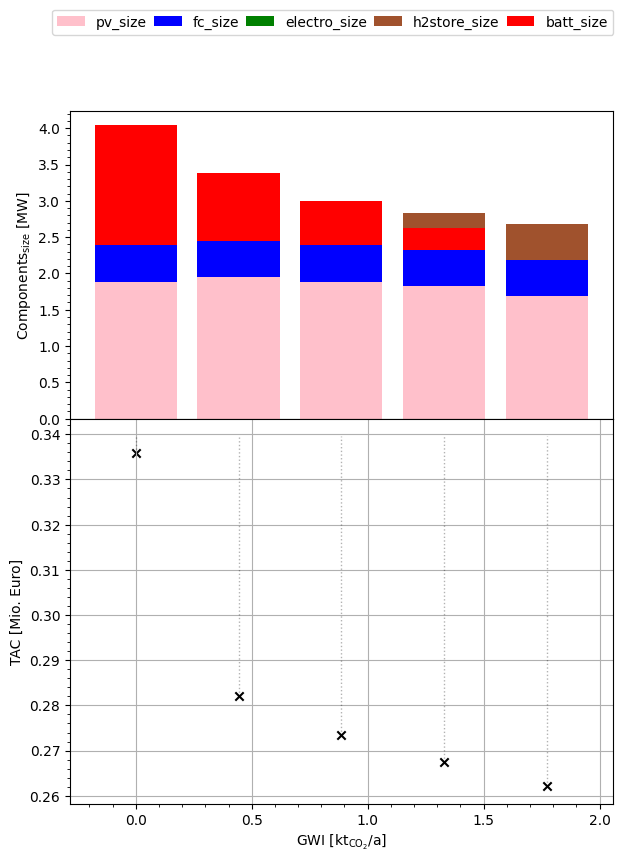

In [50]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(7, 9),gridspec_kw={'hspace': 0, 'height_ratios': [1.2, 1.5]})
gwi_data = obj_vals.gwi / 1e2
tac_data = obj_vals.tac / 1e6
width = (gwi_data.max() - gwi_data.min()) / len(obj_vals)
cap = dvs['value'].unstack(level=1) / 1e3
axs[0].bar(gwi_data, cap['pv_size'], width=width, color='pink')
axs[0].bar(gwi_data, cap['fc_size'], bottom=cap['pv_size'],width=width, color='blue')
axs[0].bar(gwi_data, cap['electro_size'], bottom=cap['pv_size']+cap['fc_size'],width=width, color='green')
axs[0].bar(gwi_data, cap['fc_size'], bottom=cap['pv_size']+cap['fc_size']+cap['electro_size'],width=width, color='sienna')
axs[0].bar(gwi_data, cap['batt_size'], bottom=cap['pv_size']+cap['fc_size']+cap['electro_size']+cap['h2store_size'],width=width, color='red')
axs[0].set_ylabel(r'Components$_{\mathrm{size}}$ [MW]')
axs[0].minorticks_on()
axs[1].scatter(gwi_data, tac_data, marker='x', color='k')
axs[1].set_xlabel(r'GWI [kt$_{\mathrm{CO}_2}$/a]')
axs[1].set_ylabel(r'TAC [Mio. Euro]')
axs[1].minorticks_on()
axs[1].vlines(gwi_data, tac_data, axs[1].get_ylim()[1], color='k', alpha=0.3,
              linestyles='dotted', linewidth=1)
fig.legend(
    ['pv_size','fc_size', 'electro_size','h2store_size','batt_size'],
    loc='upper center',ncol=7, columnspacing=0.5, bbox_to_anchor=(0.5, 1.00))
plt.savefig(f'result_Subtask4_2.png', bbox_inches='tight', dpi = 500)
plt.grid()
plt.show()